<a href="https://colab.research.google.com/github/Yash-Kavaiya/unfold_data_science/blob/main/cifar10_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CIFAR10 Dataset

The CIFAR-10 dataset is a collection of 60,000 32x32 color images of 10 different classes. The 10 classes are airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Each class contains 6,000 images. The dataset is evenly split into a training set of 50,000 images and a test set of 10,000 images. The images in the dataset are preprocessed and normalized. This dataset is commonly used as a benchmark for image classification tasks and is often used for testing new machine learning algorithms.

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

## Dowload the dataset

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [ ]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

The dataset is extracted to the directory `data/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [ ]:
data_dir = './data/cifar10'
classes = os.listdir(data_dir + "/train")
print(os.listdir(data_dir))
print(classes)

['test', 'train']
['automobile', 'deer', 'cat', 'truck', 'airplane', 'ship', 'frog', 'bird', 'dog', 'horse']


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

train_ds = ImageFolder(data_dir+'/train', transform=ToTensor())
test_ds = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: ToTensor()

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_ds

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./data/cifar10/test
    StandardTransform
Transform: ToTensor()

We can now create data loaders for training and validation, to load the data in batches

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size=200

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

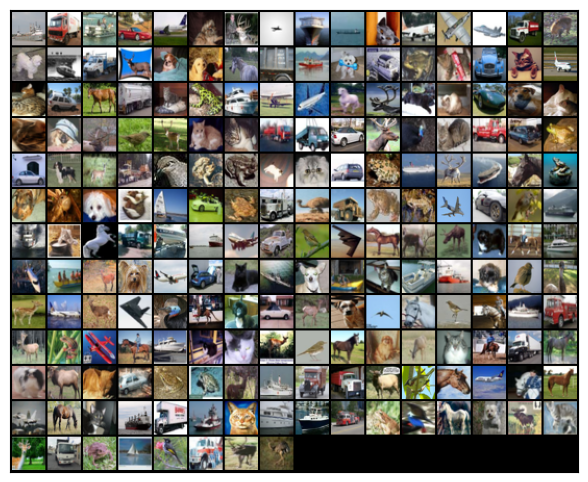

In [ ]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)
we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [ ]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output


There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2))

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([200, 3, 32, 32])
out.shape: torch.Size([200, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([200, 3, 32, 32])
out.shape: torch.Size([200, 10])
out[0]: tensor([-0.0254, -0.0362,  0.0046,  0.0378, -0.0175,  0.0213,  0.0049,  0.0292,
         0.0241,  0.0143], grad_fn=<SelectBackward0>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
evaluate(model, test_dl)

{'test_loss': 2.302985906600952, 'test_acc': 0.10000000149011612}

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 1.7980, test_loss: 1.4552, test_acc: 0.4503
Epoch [1], train_loss: 1.2886, test_loss: 1.1269, test_acc: 0.5940
Epoch [2], train_loss: 1.0084, test_loss: 0.9628, test_acc: 0.6471
Epoch [3], train_loss: 0.8127, test_loss: 0.8526, test_acc: 0.7035
Epoch [4], train_loss: 0.6632, test_loss: 0.7516, test_acc: 0.7435
Epoch [5], train_loss: 0.5508, test_loss: 0.7415, test_acc: 0.7515
Epoch [6], train_loss: 0.4454, test_loss: 0.6952, test_acc: 0.7710
Epoch [7], train_loss: 0.3381, test_loss: 0.7390, test_acc: 0.7692
Epoch [8], train_loss: 0.2573, test_loss: 0.8184, test_acc: 0.7733
Epoch [9], train_loss: 0.1885, test_loss: 1.0130, test_acc: 0.7561
Epoch [10], train_loss: 0.1423, test_loss: 0.9319, test_acc: 0.7724
Epoch [11], train_loss: 0.1132, test_loss: 1.0311, test_acc: 0.7687
Epoch [12], train_loss: 0.0906, test_loss: 1.1362, test_acc: 0.7709
Epoch [13], train_loss: 0.0773, test_loss: 1.1923, test_acc: 0.7687
Epoch [14], train_loss: 0.0785, test_loss: 1.2170, test_ac

We can also plot the valdation set accuracies to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['test_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

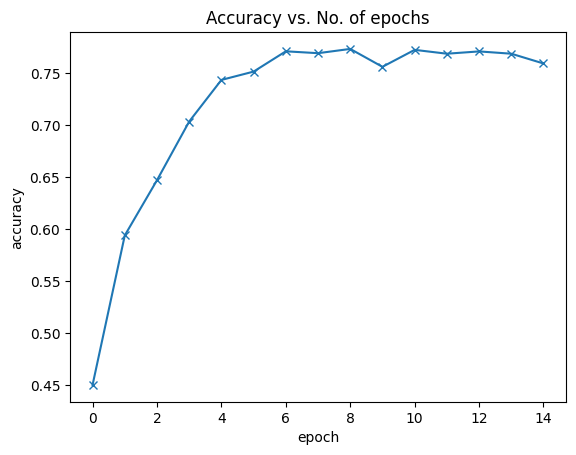

In [ ]:
plot_accuracies(history)

Our model reaches an accuracy of around 75%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 80% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer, or by using regularization techniques.

We can also plot the training and validation losses to study the trend.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Testing'])
    plt.title('Loss vs. No. of epochs');

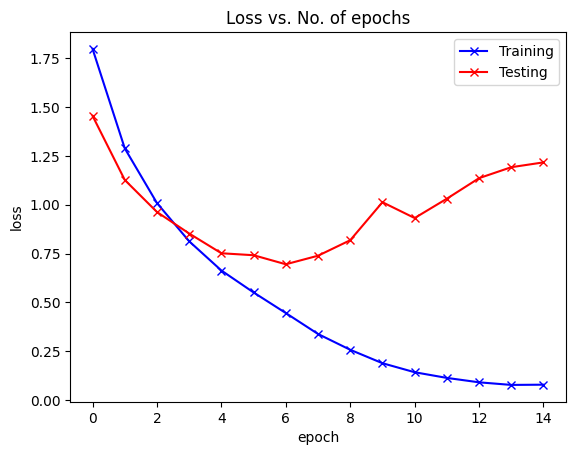

In [ ]:
plot_losses(history)

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

We expect these values to be similar to those for the validation set. If not, we might need a better testing set that has similar data and distribution as the test set (which often comes from real world data).

## Summary 
* Introduction to the CIFAR10 dataset for image classification
* Downloading, extracing and loading an image dataset using `torchvision`
* Creating a convolutional neural network using with `nn.Conv2d` and `nn.MaxPool2d` layers
* Training a convolutional neural network and visualizing the losses and errors




